In [85]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point
import geopandas as gpd
import contextily as ctx
from config import create_connection_obj

pd.set_option('display.max_columns', None)
sns.set_theme(style="whitegrid")

In [6]:
conn = create_connection_obj()

rawdata = pd.read_sql(sql="SELECT * FROM raw_redfin_data;", con=conn)

In [90]:
def process_raw_data(df):
    """Filter on relevant observations, convert to GeoDataFrame, and drop uncessary columns

    Args:
        df (pd.DataFrame): Raw Redfin data queries from db
    Output:
        df (gpd.GeoDataFrame)
    """
    to_drop = [
        'SALE_TYPE',
        'PROPERTY_TYPE',
        'STATE',
        'LOT_SIZE',
        'LOCATION',
        'DAYS_ON_MARKET',
        'STATUS',
        'NEXT_OPEN_HOUSE_START_TIME',
        'NEXT_OPEN_HOUSE_END_TIME',
        'URL',
        'SOURCE',
        'MLS',
        'FAVORITE',
        'INTERESTED',
        'CITY',
        'SOLD_DATE'
        ]

    def convert_to_geodataframe(df_):
        coords = list(zip(df_['LONGITUDE'], df_['LATITUDE']))
        geos = [Point(xy) for xy in coords]
        return gpd.GeoDataFrame(df_, geometry=geos, crs="EPSG:4269")

    return (
        df
        .query("PROPERTY_TYPE == 'Condo/Co-op' & CITY == 'Portland'")
        .pipe(convert_to_geodataframe)
        .astype({'SOLD_DATE':'datetime64'})
        .assign(
            SOLD_YEAR=lambda df_: df_['SOLD_DATE'].dt.year,
            SOLD_MONTH=lambda df_: df_['SOLD_DATE'].dt.month
            )
        .drop(to_drop, axis=1)
        )
    
    
df = process_raw_data(rawdata)

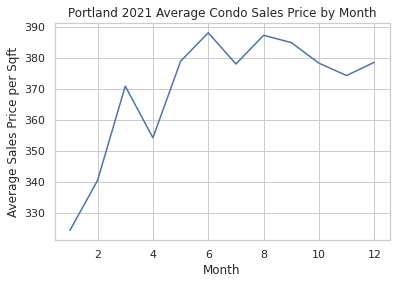

In [91]:
_ = (
    df
    .groupby(['SOLD_YEAR', 'SOLD_MONTH'])
    .agg(
        avg_price_per_sqft=('PRICE_PER_SQUARE_FEET', 'mean'),
        n_sales=('PRICE_PER_SQUARE_FEET', 'count'),
        )
    .reset_index()
    .query("SOLD_YEAR == 2021")
    .plot(kind='line', x='SOLD_MONTH', y='avg_price_per_sqft', legend=False)
    )

plt.title('Portland 2021 Average Condo Sales Price by Month')
plt.xlabel('Month')
plt.ylabel('Average Sales Price per Sqft')
plt.show()

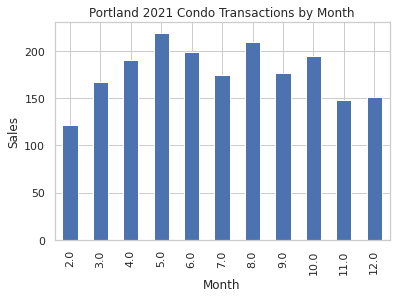

In [92]:
_ = (
    df
    .groupby(['SOLD_YEAR', 'SOLD_MONTH'])
    .agg(
        avg_price_per_sqft=('PRICE_PER_SQUARE_FEET', 'mean'),
        n_sales=('PRICE_PER_SQUARE_FEET', 'count'),
        )
    .reset_index()
    .query("SOLD_YEAR == 2021 & SOLD_MONTH > 1")
    .plot(kind='bar', x='SOLD_MONTH', y='n_sales', legend=False)
    )

plt.title('Portland 2021 Condo Transactions by Month')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.show()

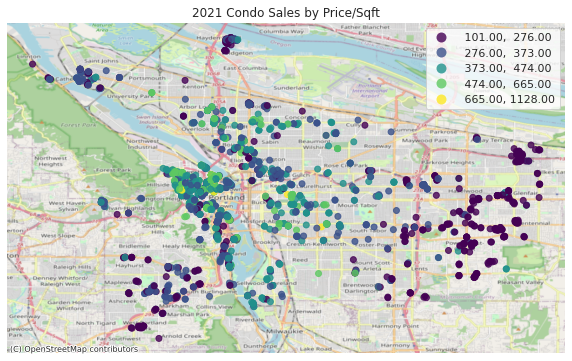

In [93]:
ax = df.plot(column='PRICE_PER_SQUARE_FEET', legend=True, scheme='fisherjenks', figsize=(10, 8), alpha=0.8)
ctx.add_basemap(ax=ax, crs=df.crs, source=ctx.providers.OpenStreetMap.Mapnik)
plt.axis('off')
plt.title('2021 Condo Sales by Price/Sqft')
plt.show()

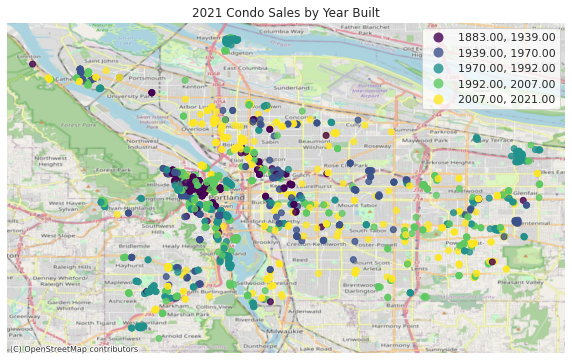

In [94]:
ax = df.plot(column='YEAR_BUILT', legend=True, scheme='fisherjenks', figsize=(10, 8), alpha=0.8)
ctx.add_basemap(ax=ax, crs=df.crs, source=ctx.providers.OpenStreetMap.Mapnik)
plt.axis('off')
plt.title('2021 Condo Sales by Year Built')
plt.show()

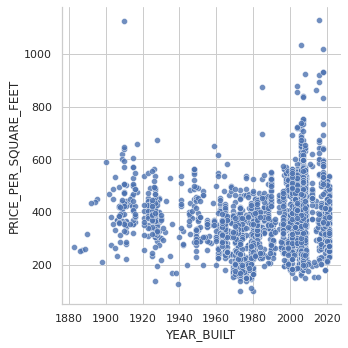

In [95]:
sns.relplot(
    x='YEAR_BUILT',
    y='PRICE_PER_SQUARE_FEET',
    data=df,
    alpha=0.8
    )

Start working through feature engineering on the address field. An initial idea that comes to mind it to try and extract the floor of the condo based on the unit number. Additionally, it might be possible to get at some building level fixed effects or something similar if I can extract the building from the first part of the address. 

In [113]:
df['ADDRESS'].str.extract('(\d{,5})', expand=True)

,0
0,971
1,359
2,2005
3,215
4,762
...,...
2287,1930
2288,1030
2289,1030
2290,1030
